# Enunciado do trabalho 2 - individual

Com este trabalho pretende-se que os alunos explorem GANs e/ou Autoencoders num problema à escolha do aluno. Há imensos datasets disponíveis para treinar este tipo de redes.

O objectivo principal é explorar as funções de erro, por exemplo na linha do que foi feito na Pix2Pix ou Cycle GAN, e/ou explorar manipulações e combinações de datasets.

O relatório deve ser sucinto, podendo estar incluído no próprio notebook, e deverá conter a descrição da estratégia definida pelos alunos assim como uma discussão/comparação dos resultados obtidos. No caso da comparação esta deverá ser feita com base em resultados publicados por terceiros.

Submissão via BB.

Data final de submissão: 18 de Junho

https://medium.com/@chloelim608/converting-landscapes-into-minecraft-images-with-cyclegan-dd12c284659b

In [81]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
from tqdm import tqdm

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

import kagglehub

import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Componentes do Modelo

https://github.com/henry32144/cyclegan-notebook/blob/master/pytorch_cycle_gan.ipynb

# Download datasets

In [82]:
landscape_dataset = kagglehub.dataset_download(
    "utkarshsaxenadn/landscape-recognition-image-dataset-12k-images"
)
minecraft_dataset = kagglehub.dataset_download(
    "pr1m3r/minecraft-dimensions-screenshots"
)

print(landscape_dataset)
print(minecraft_dataset)

C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3


# Carregar imagens

In [83]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# Define transforms
transform = transforms.Compose(
    [
        # transforms.Resize((256, 256)),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

landscape_dataset_path = (
    pathlib.Path(landscape_dataset)
    / "Landscape Classification"
    / "Landscape Classification"
    / "Training Data"
)

minecraft_dataset_path = (
    pathlib.Path(minecraft_dataset) / "data" / "nether_comparison_data" / "overworld_sc"
)

print(landscape_dataset_path)
print(minecraft_dataset_path)

# Get image paths
landscape_images = list(landscape_dataset_path.glob("**/*.jpeg"))
minecraft_images = list(minecraft_dataset_path.glob("**/*.png"))

print(f"Found {len(landscape_images)} landscape images")
print(f"Found {len(minecraft_images)} minecraft images")

# Create datasets
landscape_pytorch_dataset = ImageDataset(landscape_images, transform=transform)
minecraft_pytorch_dataset = ImageDataset(minecraft_images, transform=transform)

# Create data loaders
batch_size = 8
landscape_loader = torch.utils.data.DataLoader(
    landscape_pytorch_dataset, batch_size=batch_size, shuffle=True
)
minecraft_loader = torch.utils.data.DataLoader(
    minecraft_pytorch_dataset, batch_size=batch_size, shuffle=True
)

print(
    f"Landscape dataset: {len(landscape_pytorch_dataset)} images, {len(landscape_loader)} batches"
)
print(
    f"Minecraft dataset: {len(minecraft_pytorch_dataset)} images, {len(minecraft_loader)} batches"
)


C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3\Landscape Classification\Landscape Classification\Training Data
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3\data\nether_comparison_data\overworld_sc
Found 10000 landscape images
Found 300 minecraft images
Landscape dataset: 10000 images, 1250 batches
Minecraft dataset: 300 images, 38 batches


Sample landscape images:


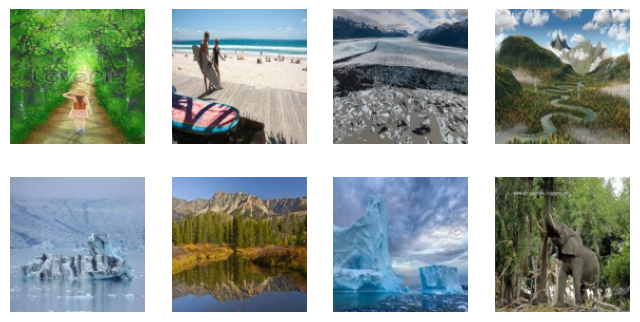

<Figure size 640x480 with 0 Axes>

Sample minecraft images:


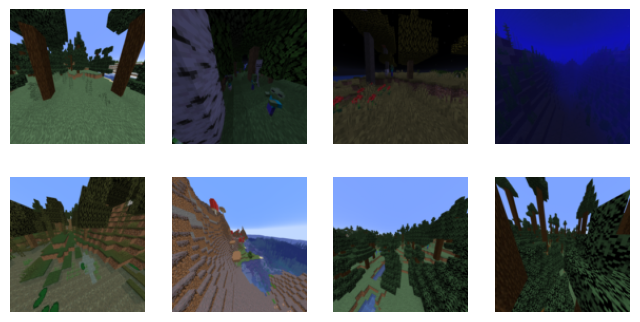

<Figure size 640x480 with 0 Axes>

In [92]:
landscape_batch = next(iter(landscape_loader))
minecraft_batch = next(iter(minecraft_loader))


def show_images(rows, cols, images):
    width = 2 * rows
    height = 2 * cols

    f, axes = plt.subplots(rows, cols, figsize=(height, width))
    fig = plt.figure()

    for a in range(rows * cols):
        axes.ravel()[a].imshow(
            np.clip(np.transpose(images[a].numpy(), (1, 2, 0)) * 0.5 + 0.5, 0, 1),
            cmap=plt.cm.gray,
        )
        axes.ravel()[a].axis("off")
    fig.tight_layout()
    plt.show()


print("Sample landscape images:")
show_images(2, 4, landscape_batch[:8])

print("Sample minecraft images:")
show_images(2, 4, minecraft_batch[:8])

# Generator (CycleGAN)
https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

In [85]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        **kwargs,
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Conv2d(
                in_channels, out_channels, padding_mode="reflect", **kwargs
            )
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)

        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 x 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1-3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

# Discriminator

In [86]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=stride,
            padding=1,
            bias=True,
            padding_mode="reflect",
        )
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return self.model(x)

# Training

In [87]:
# Training Configuration
DEVICE = device
LAMBDA_CYCLE = 10.0  # weight for cycle consistency loss
LEARNING_RATE = 2e-4
BETAS = (0.5, 0.999)  # Adam optimizer betas
NUM_EPOCHS = 80

# Create outputs directory if it doesn't exist
os.makedirs("outputs", exist_ok=True)


In [88]:
def train_fn(
    disc_minecraft,
    disc_landscape,
    gen_landscape,
    gen_minecraft,
    loader,
    opt_disc,
    opt_gen,
    l1,
    mse,
    d_scaler,
    g_scaler,
    epoch,
):
    """
    Adapted training function for Minecraft-GAN:
    - disc_minecraft: Discriminator for Minecraft domain
    - disc_landscape: Discriminator for Landscape domain
    - gen_landscape: Generator that converts Minecraft -> Landscape
    - gen_minecraft: Generator that converts Landscape -> Minecraft
    """
    minecraft_reals = 0
    minecraft_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (landscape, minecraft) in enumerate(loop):
        landscape = landscape.to(DEVICE)
        minecraft = minecraft.to(DEVICE)

        # Train discriminators for Minecraft and Landscape domains
        with torch.autocast(device_type="cuda"):
            # Generate fake minecraft from landscape
            fake_minecraft = gen_minecraft(landscape)
            D_minecraft_real = disc_minecraft(minecraft)
            D_minecraft_fake = disc_minecraft(fake_minecraft.detach())
            minecraft_reals += D_minecraft_real.mean().item()
            minecraft_fakes += D_minecraft_fake.mean().item()
            D_minecraft_real_loss = mse(
                D_minecraft_real, torch.ones_like(D_minecraft_real)
            )
            D_minecraft_fake_loss = mse(
                D_minecraft_fake, torch.zeros_like(D_minecraft_fake)
            )
            D_minecraft_loss = D_minecraft_real_loss + D_minecraft_fake_loss

            # Generate fake landscape from minecraft
            fake_landscape = gen_landscape(minecraft)
            D_landscape_real = disc_landscape(landscape)
            D_landscape_fake = disc_landscape(fake_landscape.detach())
            D_landscape_real_loss = mse(
                D_landscape_real, torch.ones_like(D_landscape_real)
            )
            D_landscape_fake_loss = mse(
                D_landscape_fake, torch.zeros_like(D_landscape_fake)
            )
            D_landscape_loss = D_landscape_real_loss + D_landscape_fake_loss

            # Total discriminator loss
            D_loss = (D_minecraft_loss + D_landscape_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators for both domains
        with torch.autocast(device_type="cuda"):
            # Adversarial losses for generators
            D_minecraft_fake = disc_minecraft(fake_minecraft)
            D_landscape_fake = disc_landscape(fake_landscape)
            loss_G_minecraft = mse(D_minecraft_fake, torch.ones_like(D_minecraft_fake))
            loss_G_landscape = mse(D_landscape_fake, torch.ones_like(D_landscape_fake))

            # Cycle consistency losses
            cycle_landscape = gen_landscape(fake_minecraft)
            cycle_minecraft = gen_minecraft(fake_landscape)
            cycle_landscape_loss = l1(landscape, cycle_landscape)
            cycle_minecraft_loss = l1(minecraft, cycle_minecraft)

            # Total generator loss
            G_loss = (
                loss_G_landscape
                + loss_G_minecraft
                + cycle_landscape_loss * LAMBDA_CYCLE
                + cycle_minecraft_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx == 0:
            save_image(fake_minecraft * 0.5 + 0.5, f"outputs/minecraft_{epoch}_{idx}.png")
            save_image(fake_landscape * 0.5 + 0.5, f"outputs/landscape_{epoch}_{idx}.png")

        loop.set_postfix(
            minecraft_real=minecraft_reals / (idx + 1),
            minecraft_fake=minecraft_fakes / (idx + 1),
        )


In [89]:
def create_combined_loader(landscape_loader, minecraft_loader, max_batches=None):
    """
    Create a combined data loader that yields pairs of (landscape, minecraft) batches.
    Since the datasets have different sizes, we'll cycle through the smaller one.
    """
    landscape_iter = iter(landscape_loader)
    minecraft_iter = iter(minecraft_loader)
    
    batches_processed = 0
    
    while True:
        try:
            landscape_batch = next(landscape_iter)
        except StopIteration:
            landscape_iter = iter(landscape_loader)
            landscape_batch = next(landscape_iter)
            
        try:
            minecraft_batch = next(minecraft_iter)
        except StopIteration:
            minecraft_iter = iter(minecraft_loader)
            minecraft_batch = next(minecraft_iter)
            
        # Ensure both batches have the same size
        min_size = min(landscape_batch.size(0), minecraft_batch.size(0))
        landscape_batch = landscape_batch[:min_size]
        minecraft_batch = minecraft_batch[:min_size]
        
        yield landscape_batch, minecraft_batch
        
        batches_processed += 1
        if max_batches and batches_processed >= max_batches:
            break


In [90]:
# Initialize models
disc_minecraft = Discriminator(in_channels=3).to(DEVICE)
disc_landscape = Discriminator(in_channels=3).to(DEVICE)
gen_landscape = Generator(img_channels=3, num_features=64).to(DEVICE)  # Minecraft -> Landscape
gen_minecraft = Generator(img_channels=3, num_features=64).to(DEVICE)  # Landscape -> Minecraft

# Initialize optimizers
opt_disc = optim.Adam(
    list(disc_minecraft.parameters()) + list(disc_landscape.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)
opt_gen = optim.Adam(
    list(gen_landscape.parameters()) + list(gen_minecraft.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)

# Loss functions
L1 = nn.L1Loss()
mse = nn.MSELoss()

# Gradient scalers for mixed precision training
g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

print("Models and optimizers initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in gen_minecraft.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc_minecraft.parameters()):,}")


Models and optimizers initialized successfully!
Generator parameters: 7,837,699
Discriminator parameters: 2,764,737


In [91]:
# Main training loop
print("Starting training...")

max_possible_batches = max(len(landscape_loader), len(minecraft_loader))
batches_per_epoch = min(100, max_possible_batches)  # Limit to 100 batches per epoch
print(f"Maximum possible batches: {max_possible_batches}")
print(f"Reduced batches per epoch: {batches_per_epoch}")

for epoch in range(NUM_EPOCHS):
    print(f"\n=== Epoch {epoch + 1}/{NUM_EPOCHS} ===")

    # Create combined data loader for this epoch
    combined_loader = create_combined_loader(
        landscape_loader, minecraft_loader, max_batches=batches_per_epoch
    )

    # Train for one epoch
    train_fn(
        disc_minecraft=disc_minecraft,
        disc_landscape=disc_landscape,
        gen_landscape=gen_landscape,
        gen_minecraft=gen_minecraft,
        loader=combined_loader,
        opt_disc=opt_disc,
        opt_gen=opt_gen,
        l1=L1,
        mse=mse,
        d_scaler=d_scaler,
        g_scaler=g_scaler,
        epoch=epoch
    )

    # Save model checkpoints every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            "gen_minecraft_state_dict": gen_minecraft.state_dict(),
            "gen_landscape_state_dict": gen_landscape.state_dict(),
            "disc_minecraft_state_dict": disc_minecraft.state_dict(),
            "disc_landscape_state_dict": disc_landscape.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_disc_state_dict": opt_disc.state_dict(),
            "epoch": epoch,
        }
        torch.save(checkpoint, f"outputs/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

print("Training completed!")


Starting training...
Maximum possible batches: 1250
Reduced batches per epoch: 100

=== Epoch 1/80 ===


100it [00:25,  3.97it/s, minecraft_fake=0.337, minecraft_real=0.625]  



=== Epoch 2/80 ===


100it [00:23,  4.27it/s, minecraft_fake=0.275, minecraft_real=0.714]



=== Epoch 3/80 ===


100it [00:23,  4.30it/s, minecraft_fake=0.27, minecraft_real=0.725]



=== Epoch 4/80 ===


100it [00:24,  4.06it/s, minecraft_fake=0.264, minecraft_real=0.733]



=== Epoch 5/80 ===


100it [00:23,  4.22it/s, minecraft_fake=0.248, minecraft_real=0.745]



=== Epoch 6/80 ===


74it [00:18,  3.99it/s, minecraft_fake=0.222, minecraft_real=0.776]


KeyboardInterrupt: 

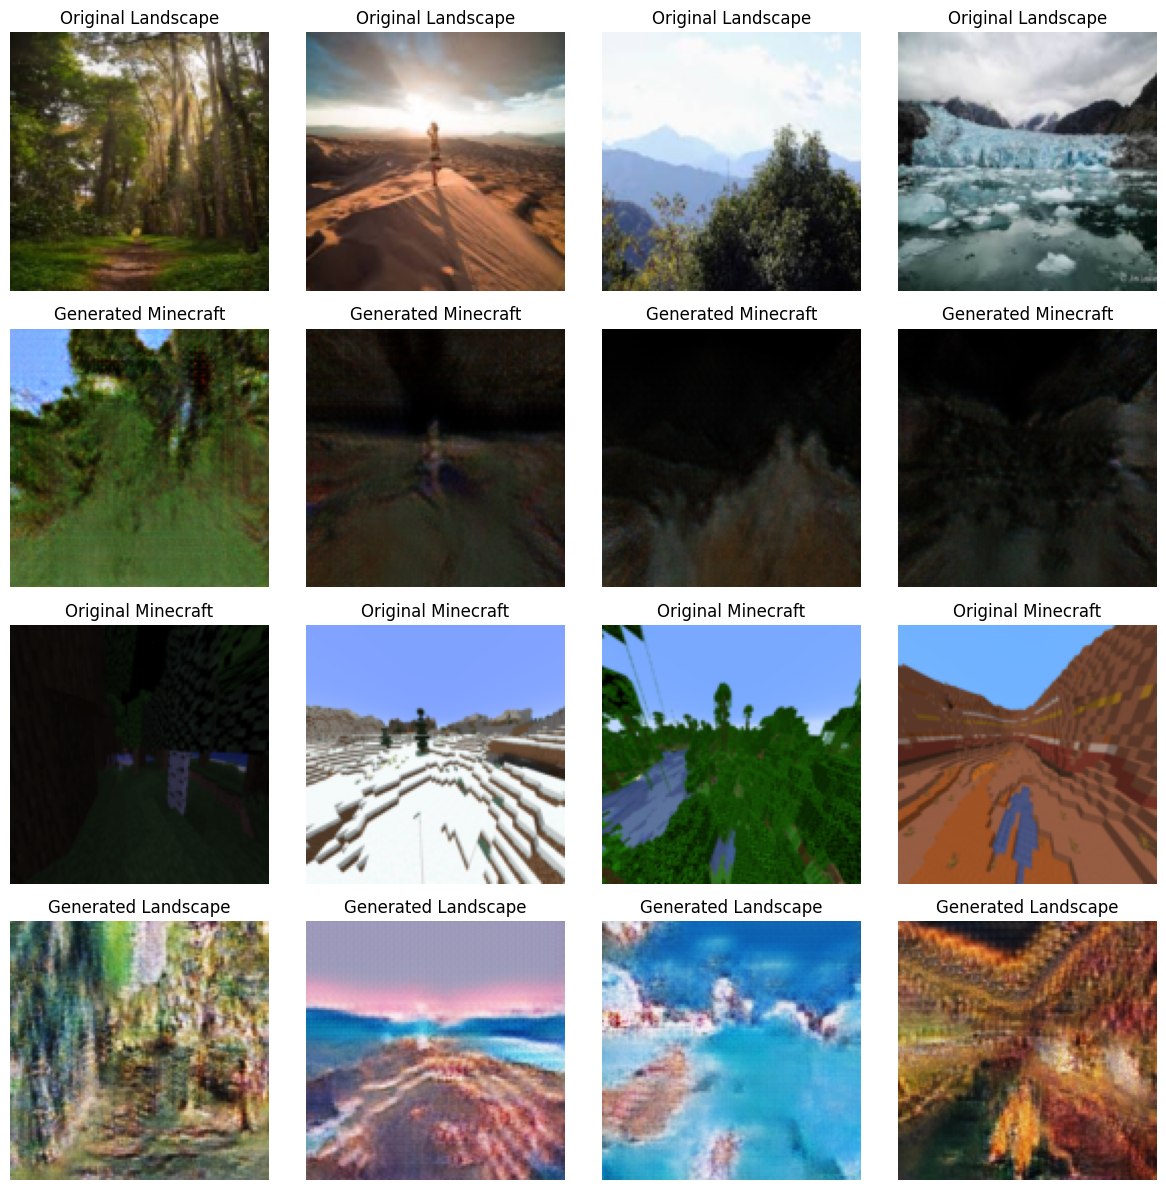

In [ ]:
# Utility function to visualize results
def visualize_results(gen_minecraft, gen_landscape, landscape_batch, minecraft_batch, num_samples=4):
    """
    Visualize the results of the generators on sample batches
    """
    gen_minecraft.eval()
    gen_landscape.eval()
    
    with torch.no_grad():
        # Convert landscape to minecraft
        fake_minecraft = gen_minecraft(landscape_batch[:num_samples].to(DEVICE))
        # Convert minecraft to landscape  
        fake_landscape = gen_landscape(minecraft_batch[:num_samples].to(DEVICE))
        
        # Denormalize images for visualization (from [-1,1] to [0,1])
        landscape_viz = landscape_batch[:num_samples] * 0.5 + 0.5
        minecraft_viz = minecraft_batch[:num_samples] * 0.5 + 0.5
        fake_minecraft_viz = fake_minecraft.cpu() * 0.5 + 0.5
        fake_landscape_viz = fake_landscape.cpu() * 0.5 + 0.5
        
        # Create visualization
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))
        
        for i in range(num_samples):
            # Original landscape
            axes[0, i].imshow(np.transpose(landscape_viz[i].numpy(), (1, 2, 0)))
            axes[0, i].set_title('Original Landscape')
            axes[0, i].axis('off')
            
            # Generated minecraft from landscape
            axes[1, i].imshow(np.transpose(fake_minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[1, i].set_title('Generated Minecraft')
            axes[1, i].axis('off')
            
            # Original minecraft
            axes[2, i].imshow(np.transpose(minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[2, i].set_title('Original Minecraft')
            axes[2, i].axis('off')
            
            # Generated landscape from minecraft
            axes[3, i].imshow(np.transpose(fake_landscape_viz[i].numpy(), (1, 2, 0)))
            axes[3, i].set_title('Generated Landscape')
            axes[3, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    gen_minecraft.train()
    gen_landscape.train()

# Example usage (uncomment to test):
landscape_sample = next(iter(landscape_loader))
minecraft_sample = next(iter(minecraft_loader))
visualize_results(gen_minecraft, gen_landscape, landscape_sample, minecraft_sample)
